In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from util.lexicon_dataloader import LexiconDataLoader
from util.corpus_dataloader import CorpusDataLoader, LyricsTokenizer
from model.lexicon_model import Lexicon

/home/kunnic/code/song-corpus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kunnic/code/song-corpus/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 12020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
LEXICON_PATH = "data/VnEmoLex.xlsx"
CORPUS_PATH = "data/corpus.csv"

In [16]:
lexicon = LexiconDataLoader(LEXICON_PATH)
corpus = CorpusDataLoader(CORPUS_PATH)

Lexicon loaded: 10626 words.
Corpus loaded: 62275 records.


In [18]:
tokenizer = LyricsTokenizer()
dataframe = tokenizer.transform(corpus.data)

Tokenizing 'lyrics' column...
Tokenization complete.


In [19]:
model = Lexicon(lexicon_dict=lexicon.data)
results = model.predict_dataset(
    dataframe, 
    tokenized_col_name="lyrics_tokenized"
)

Processing: 100%|██████████| 62275/62275 [00:06<00:00, 9314.73it/s] 


In [47]:
results.to_csv("data/lexicon_predicted_dataset.csv", index=False)

In [48]:
#remove year that are NaN and 0
results = results[results['year'].notna()]
results = results[(results['year'] != 0) & (results['year'] > 1900)]

TEST HERE

In [109]:
manually_labeled = pd.read_csv("data/manually_labeled.csv")

# Name column change
manually_labeled = manually_labeled.rename(columns={"text_segment": "lyrics_tokenized"})
lexicon_predicted_dataset = pd.read_csv("data/lexicon_predicted_dataset.csv")

In [110]:
lexicon_predicted_dataset.columns

Index(['title', 'composers', 'lyricists', 'year', 'genres', 'lyrics', 'urls',
       'source', 'note', 'lyrics_tokenized', 'top_emotion', 'word_count',
       'positive', 'negative', 'anger', 'anticipation', 'disgust', 'fear',
       'joy', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [111]:
removing_columns = [
    # 'id',
    # 'title',
    # 'composers',
    'genres',
    'lyrics',
    'text_segment',
    # 'label_emotion',
    'confidence_score',
    'label_source',
    'lyricists',
    'year',
    'urls',
    'source',
    'note',
    # 'top_emotion',
    'word_count',
    'positive',
    'negative',
    'anger',
    'anticipation',
    'disgust',
    'fear',
    'joy',
    'sadness',
    'surprise',
    'trust',
    'lyrics_tokenized'
]

for col in removing_columns:
    if col in lexicon_predicted_dataset.columns:
        lexicon_predicted_dataset = lexicon_predicted_dataset.drop(columns=[col])
    if col in manually_labeled.columns:
        manually_labeled = manually_labeled.drop(columns=[col])

In [112]:
manually_labeled.head()

,id,title,composers,label_emotion
0,60637,xin trả lại anh,Yêu Thoáng Qua 1986,2-Buồn
1,56443,từ lúc yêu em,Vô Thường,2-Buồn
2,38494,Ngày Xuân Long Phụng Sum Vầy,"Quang Huy, Bích Phương, Dương Minh Ngọc, Dương...",1-Vui
3,18601,duyên nợ bẽ bàng,Hoài Phong,2-Buồn
4,29985,liên khúc mặt trời đen đêm dài,"Nguyễn Trung Cang, Lê Hựu Hà",2-Buồn


In [113]:
lexicon_predicted_dataset.head()

,title,composers,top_emotion
0,10,['DTAP'],trust
1,12,"['Hoàng Tôn', 'Mr. A']",anticipation
2,15,['Nguyen Bao Tung'],joy
3,20,['Thanh Duy'],joy
4,22,['Trang'],anticipation


In [114]:
# Group by title + composer
merged = pd.merge(
    manually_labeled,
    lexicon_predicted_dataset,
    on=['title'],
    how='inner'
)

In [115]:
# sort by id
merged = merged.sort_values(by=['id'])
merged.head()

,id,title,composers_x,label_emotion,composers_y,top_emotion
4679,1,10,DTAP,2-Buồn,['DTAP'],trust
4833,10,123,Super T,1-Vui,['Super T'],joy
1013,10,123,Super T,1-Vui,['Super T'],joy
4263,10,123,Super T,1-Vui,['Super T'],joy
2648,56,1 dặm 1600 mét một dặm 1600 mét,Đoàn Đình Duy,2-Buồn,['Đoàn Đình Duy'],anticipation


In [119]:
score = merged.sample(frac=0.1, random_state=69).reset_index(drop=True)

In [ ]:
score['top_emotion'] = score['top_emotion'].replace({'anticipation': 'surprise', 'trust': 'joy'})
score.head()
score = score[score['top_emotion'] != 'neutral']

score['label_emotion'] = score['label_emotion'].replace(
    {'1-Vui': 'joy', 
     '2-Buồn': 'sadness', 
     '3-Giận dữ': 'anger', 
     '4-Sợ hãi': 'fear', 
     '5-Ghê tởm': 'disgust', 
     '6-Ngạc nhiên': 'surprise'}
)

In [ ]:
# cal accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_true = score['label_emotion']
y_pred = score['top_emotion']

# accuracy
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

Accuracy: 0.2832
Precision: 0.4416
Recall: 0.2832
F1-score: 0.2270

Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        77
     disgust       0.00      0.00      0.00        17
        fear       0.00      0.00      0.00        30
         joy       0.33      0.84      0.48       151
     sadness       0.72      0.12      0.21       283
    surprise       0.02      0.14      0.04        21

    accuracy                           0.28       579
   macro avg       0.18      0.18      0.12       579
weighted avg       0.44      0.28      0.23       579



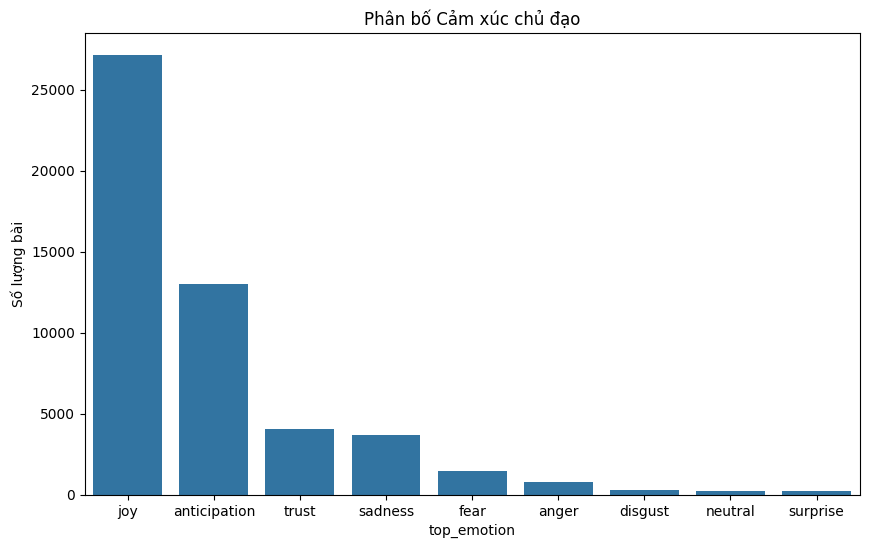

In [122]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=results, 
    x='top_emotion', 
    order=results['top_emotion'].value_counts().index
)

plt.title('Phân bố Cảm xúc chủ đạo')
plt.ylabel('Số lượng bài')
plt.show()

In [10]:
# Check the structure of results dataframe
print(results.columns.tolist())
print(f"\nShape: {results.shape}")

['title', 'composers', 'lyricists', 'year', 'genres', 'lyrics', 'urls', 'source', 'note', 'lyrics_tokenized', 'top_emotion', 'word_count', 'positive', 'negative', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

Shape: (50875, 22)


In [11]:
df_viz = results.copy()
df_viz['year'] = pd.to_numeric(df_viz['year'], errors='coerce')
df_viz = df_viz[(df_viz['year'] >= 2000) & (df_viz['year'] <= 2024)]

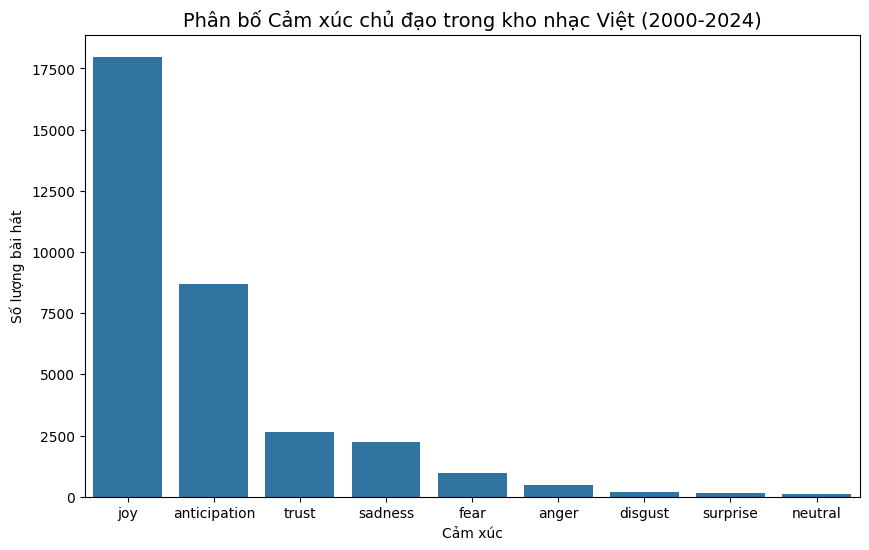

In [12]:
plt.figure(figsize=(10, 6))

emotion_counts = df_viz['top_emotion'].value_counts()

ax = sns.barplot(
    x=emotion_counts.index, 
    y=emotion_counts.values
)

plt.title('Phân bố Cảm xúc chủ đạo trong kho nhạc Việt (2000-2024)', fontsize=14)
plt.ylabel('Số lượng bài hát')
plt.xlabel('Cảm xúc')

plt.show()

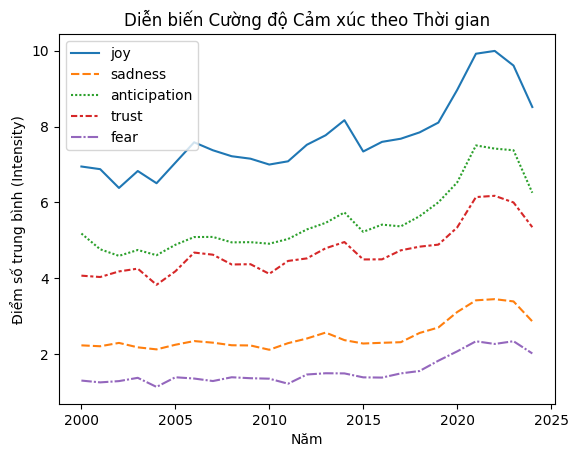

In [14]:
yearly_trends = df_viz.groupby('year')[['joy', 'sadness', 'anticipation', 'trust', 'fear']].mean()

sns.lineplot(data=yearly_trends)

plt.title('Diễn biến Cường độ Cảm xúc theo Thời gian')
plt.ylabel('Điểm số trung bình (Intensity)')
plt.xlabel('Năm')

plt.show()

In [26]:
emotion_list = [
    'anger', 'anticipation', 'disgust', 'fear', 
    'joy', 'sadness', 'surprise', 'trust'
]

df_genres = results.explode('genres')
df_genres = df_genres.groupby('genres')[emotion_list] \
                    .mean() \
                    .reset_index()

In [31]:
df_genres.head()

,genres,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,Ballad/Trữ Tình,0.638641,4.317421,0.586510,1.192732,6.148676,2.506472,1.303527,3.993825
1,Beat,0.715350,5.748137,0.618480,1.488823,7.958271,2.408346,1.250373,4.937407
2,Chill,0.761905,9.285714,1.095238,3.285714,11.380952,2.904762,2.333333,7.333333
3,Chế,1.000000,7.000000,1.000000,2.777778,7.333333,3.111111,1.444444,4.000000
4,Cách Mạng,0.788707,4.675774,0.395264,1.174863,8.464481,0.843352,2.444444,5.817851


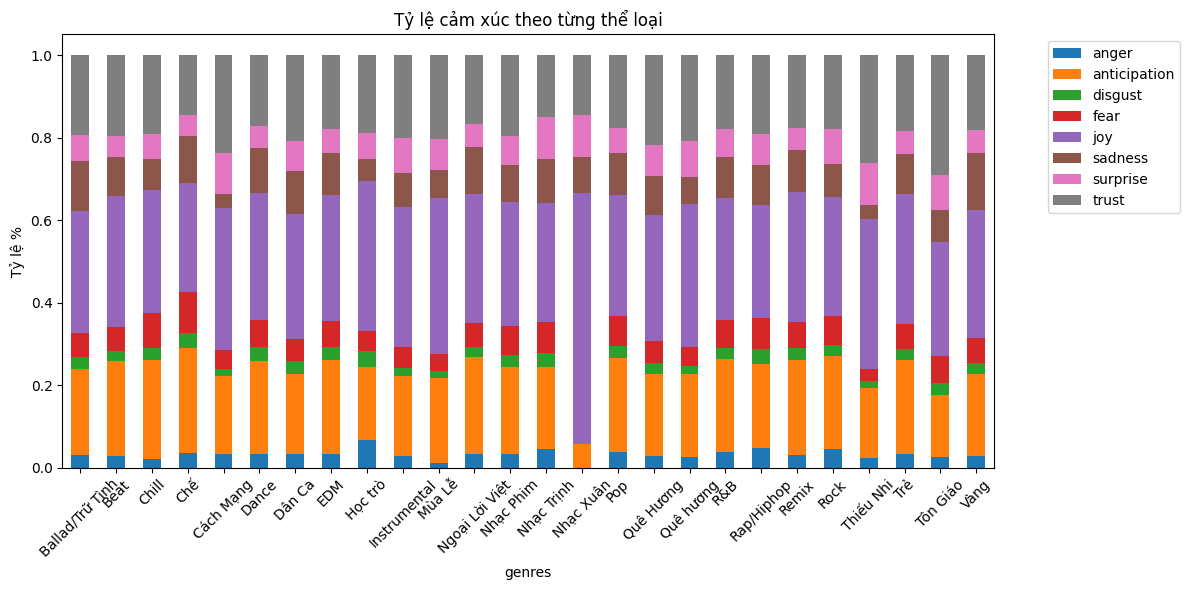

In [32]:
df_plot = df_genres.set_index('genres')
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)

df_plot.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6)
)

plt.title('Tỷ lệ cảm xúc theo từng thể loại')
plt.ylabel('Tỷ lệ %')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

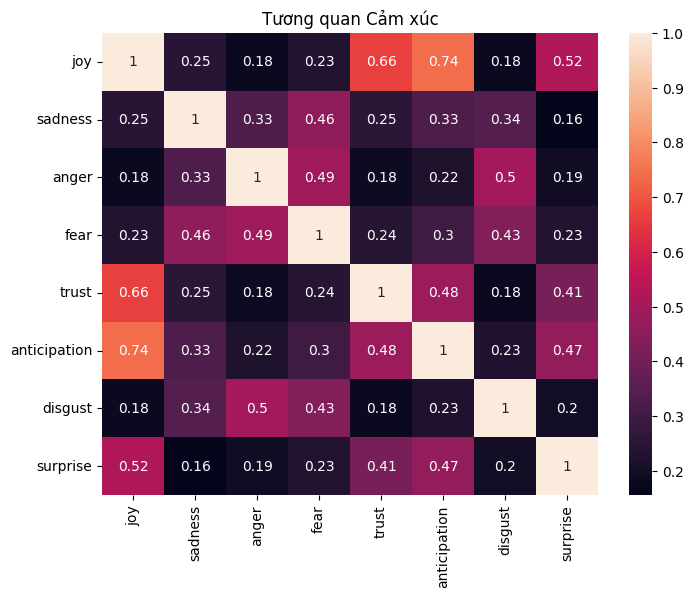

In [33]:
corr = df_viz[['joy', 'sadness', 'anger', 'fear', 'trust', 'anticipation', 'disgust', 'surprise']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True) 
plt.title('Tương quan Cảm xúc')
plt.show()